<center>
    <h1>Room Occupancy Estimation - DM, TM and BDA</h1>
    <h2>Naive Bayes</h2>
    <h3>Riccardo Spolaor</h3>
    <h4>riccardo.spolaor@studio.unibo.it</h4>
</center>

---
In this notebook the prediction task on the ***Room Occupancy Estimation*** dataset is carried out by means of Naive Bayes Classification.

## Settings

In [ ]:
import sys

IS_COLAB = 'google.colab' in sys.modules

In [ ]:
SEED=42

In [ ]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [ ]:
# Matplotlib settings

%matplotlib inline

In [ ]:
NUM_FOLDS = 10
APPLY_THRESHOLD_SELECTION = True

## Libraries

In [ ]:
if IS_COLAB:
    !pip install pyspark
    !pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=ea7c888229ff615f47c9f4da277f57a52d5be9b700eb84c91d13875487765b9e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import findspark

findspark.init()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pyspark.sql.functions as F

## Setting Spark Session

In [ ]:
from pyspark.sql import SparkSession


# Create a spark session
spark = SparkSession.builder.master('local[*]').appName('OccupancyEstimation').getOrCreate()

In [ ]:
if not IS_COLAB:
    # Put the local file in the nodes.
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -mkdir /input
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -mkdir /input/processed
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -put input/processed/train.csv /input/processed/train.csv
    !/usr/local/hadoop-3.3.4/bin/hadoop fs -put input/processed/test.csv /input/processed/test.csv

## Get the train and test data

In [ ]:
import os


if IS_COLAB:
    train_path = os.path.join('.', 'input', 'processed', 'train.csv')
    test_path = os.path.join('.', 'input', 'processed', 'test.csv')
else:
    train_path = os.path.join('/', 'input', 'processed', 'train.csv')
    test_path = os.path.join('/', 'input', 'processed', 'test.csv')

In [ ]:
train = spark.read.csv(
    train_path,
    header=True,
    inferSchema=True)

test = spark.read.csv(
    test_path,
    header=True,
    inferSchema=True)

In [ ]:
train.printSchema()
test.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- S1_Temp: double (nullable = true)
 |-- S2_Temp: double (nullable = true)
 |-- S3_Temp: double (nullable = true)
 |-- S4_Temp: double (nullable = true)
 |-- S1_Light: integer (nullable = true)
 |-- S2_Light: integer (nullable = true)
 |-- S3_Light: integer (nullable = true)
 |-- S4_Light: integer (nullable = true)
 |-- S1_Sound: double (nullable = true)
 |-- S2_Sound: double (nullable = true)
 |-- S3_Sound: double (nullable = true)
 |-- S4_Sound: double (nullable = true)
 |-- S5_CO2: integer (nullable = true)
 |-- S5_CO2_Slope: double (nullable = true)
 |-- S6_PIR: integer (nullable = true)
 |-- S7_PIR: integer (nullable = true)
 |-- Room_Occupancy_Count: integer (nullable = true)

root
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- S1_Temp: double (nullable = true)
 |-- S2_Temp: double (nullable = true)
 |-- S3_Temp: double (nullable = true)
 |-- S4_Temp: double (nullable =

In [ ]:
print('Number of train instances:', train.count())
print('Number of test instances:', test.count())

Number of train instances: 8036
Number of test instances: 2093


## Dataset Processing
In this section the dataset is processed, by adding a weight column to each instance inversely proportional to the frequency of their label, in order to address the issue of class imbalance.

The applied weight $w$, to an instance $x$ of the train dataset $\mathcal{D}$ with label $c$, is assigned by this formula:
$$w(x) = \frac{\text{lenght}(\mathcal{D})}{\text{lenght}(\mathcal{C}) \cdot \text{lenght}(\mathcal{D}_{c})}$$
where $\mathcal{D}_{c}$ is the fraction of the train dataset containing label $c$ and $\mathcal{C}$ is the set of possible labels.

Furthermore a fold column is added, to identify for each instance in which fold of the *K-fold Cross Validation* it is part of.
The folds are computed by dividing each day in $10$ different parts while guaranteeing that each fold contains a number of instances of each label that represents the distribution of the training set. Subsequent instances for each label are assigned to the same fold.

In addition, the `S5_CO2_Slope` column is normalized towards non-negative values, in order to guarantee that multinomil distribution could also be applied as an hyperparameter.

In [ ]:
train = train.withColumn('S5_CO2_Slope', F.col('S5_CO2_Slope') + F.lit(20))
test = test.withColumn('S5_CO2_Slope', F.col('S5_CO2_Slope') + F.lit(20))

In [ ]:
from pyspark.ml.feature import StandardScaler, RFormula


rf = RFormula(formula='Room_Occupancy_Count ~ . - Date - Time')
rf_fit = rf.fit(train)
train = rf_fit.transform(train).select('features', 'label', 'Date', 'Time')
test = rf_fit.transform(test).select('features', 'label', 'Date', 'Time')

In [ ]:
train.show(n=5)
test.show(n=5)

+--------------------+-----+----------+-------------------+
|            features|label|      Date|               Time|
+--------------------+-----+----------+-------------------+
|[24.94,24.75,24.5...|  1.0|2017-12-22|2023-11-22 10:49:41|
|[24.94,24.75,24.5...|  1.0|2017-12-22|2023-11-22 10:50:12|
|[25.0,24.75,24.5,...|  1.0|2017-12-22|2023-11-22 10:50:42|
|[25.0,24.75,24.56...|  1.0|2017-12-22|2023-11-22 10:51:13|
|[25.0,24.75,24.56...|  1.0|2017-12-22|2023-11-22 10:51:44|
+--------------------+-----+----------+-------------------+
only showing top 5 rows

+--------------------+-----+----------+-------------------+
|            features|label|      Date|               Time|
+--------------------+-----+----------+-------------------+
|[25.94,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:00:23|
|[25.94,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:00:53|
|[25.94,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:01:24|
|[25.88,26.0,25.75...|  0.0|2017-12-22|2023-11-22 15:01:55|
|[25.88,26.0,25

In [ ]:
from utils import get_df_with_weight_column


# Add weight column inversely proportional to train frequency of the label.
train = get_df_with_weight_column(train)

In [ ]:
train.select('label', 'weightCol').distinct().orderBy('label').show()

+-----+-------------------+
|label|          weightCol|
+-----+-------------------+
|  0.0|0.30374962201390987|
|  1.0|  6.069486404833837|
|  2.0|   3.20414673046252|
|  3.0|  4.329741379310345|
+-----+-------------------+



In [ ]:
from utils import get_df_with_fold_column


# Add the column for stratified k-fold.
train = get_df_with_fold_column(train, NUM_FOLDS)

In [ ]:
# Drop the Date and Time features.
train = train.drop('Date', 'Time')
test = test.drop('Date', 'Time')

In [ ]:
train.groupBy('foldCol', 'label').count().orderBy('foldCol', 'label').show()

+-------+-----+-----+
|foldCol|label|count|
+-------+-----+-----+
|      0|  0.0|  664|
|      0|  1.0|   34|
|      0|  2.0|   64|
|      0|  3.0|   48|
|      1|  0.0|  662|
|      1|  1.0|   33|
|      1|  2.0|   63|
|      1|  3.0|   46|
|      2|  0.0|  661|
|      2|  1.0|   34|
|      2|  2.0|   62|
|      2|  3.0|   46|
|      3|  0.0|  662|
|      3|  1.0|   32|
|      3|  2.0|   64|
|      3|  3.0|   47|
|      4|  0.0|  660|
|      4|  1.0|   33|
|      4|  2.0|   61|
|      4|  3.0|   46|
+-------+-----+-----+
only showing top 20 rows



In [ ]:
train.show(n=5)

+-----+--------------------+-----------------+-------+
|label|            features|        weightCol|foldCol|
+-----+--------------------+-----------------+-------+
|  1.0|[24.94,24.75,24.5...|6.069486404833837|      0|
|  1.0|[24.94,24.75,24.5...|6.069486404833837|      0|
|  1.0|[25.0,24.75,24.5,...|6.069486404833837|      0|
|  1.0|[25.0,24.75,24.56...|6.069486404833837|      0|
|  1.0|[25.0,24.75,24.56...|6.069486404833837|      0|
+-----+--------------------+-----------------+-------+
only showing top 5 rows



## K-Fold Cross Validation Training
In this section a pipeline is built for the Naive Bayes Classifier model. The features are not standardized, as normalized features should not bring different results for the given model. Moreover, model takes care of the weights of the classes.

*10-Fold Cross Validation* is then applied for different parameters, namely:
* `smoothing`
* `modelType`

In [ ]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline, PipelineModel

def get_pipeline() -> PipelineModel:
    #ss = StandardScaler(inputCol='features', outputCol='scaledFeatures', withMean=True, withStd=True)

    # Create the Naive Bayes Classifier.
    nb = NaiveBayes(weightCol='weightCol')

    return Pipeline(stages=[nb])

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# Cache the df.
cached = train.cache()

pipeline = get_pipeline()
nb = pipeline.getStages()[-1]

# Build the Parameter Grid.
nb_param_grid = ParamGridBuilder()\
    .addGrid(nb.smoothing, [1.0, 1e-2, 1e-4, 1e-6, 1e-8])\
    .addGrid(nb.modelType, ['multinomial', 'gaussian'])\
    .build()
    #.addGrid(nb.thresholds, [[.5,.5,.5,.5], [.5, .2, .3, .3]]).build()

# Set the Cross Validator.
nb_cross_val = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=nb_param_grid,
    evaluator=MulticlassClassificationEvaluator(
        metricName='f1', weightCol='weightCol'),
    numFolds=NUM_FOLDS,
    parallelism=NUM_FOLDS,
    collectSubModels=True,
    seed=SEED,
    foldCol='foldCol')

In [ ]:
fit = nb_cross_val.fit(cached)

In [ ]:
print('Best parameters:')
for k, v in fit.getEstimatorParamMaps()[np.argmax(fit.avgMetrics)].items():
    print(f'- {k.name}: {v}')

Best parameters:
- smoothing: 1.0
- modelType: gaussian


## Average Results on the Validation Folds
In this section, the average results of *Cross Validation* of the model with the best found hyperparameters are computed and shown.

Furthermore, threshold selection is applied, by chosing for each label the the threshold that improves its average *F1* validation score across the folds.

The threshold $t$ changes the forecasted probability $p_c$ of an instance $x$ being part of label $c$, by computing a new probability $p_c'$, such that:
$$p_c'(x) = \frac{p_c(x)}{t}$$

Threshold selection is applied in a *OneVsRest* approximation. In other words, given a class $c$ and a threshold $t$ to test, all the other classes are combined in a class $\overline{c}$ and their probabilities are summed. The threshold for $\overline{c}$ is set at $0.5$ and the predicted label of each instance $x$ is computed as follows:

$$\text{class of} \ x =
\begin{cases}
    c, & \text{if} \ p_c(x) / t \geq p_{\overline{c}}(x) / 0.5 \\
    \overline{c}, & \text{otherwise}
\end{cases}$$

In [ ]:
from utils import get_average_validation_results


avg_validation_results = get_average_validation_results(
    fit,
    train,
    apply_threshold_selection=APPLY_THRESHOLD_SELECTION)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Average Cross Validation Metrics:
Accuracy: 0.936
F1 Macro: 0.832
F1 scores:
	Label 0: 0.979
	Label 1: 0.976
	Label 3: 0.554
	Label 2: 0.817


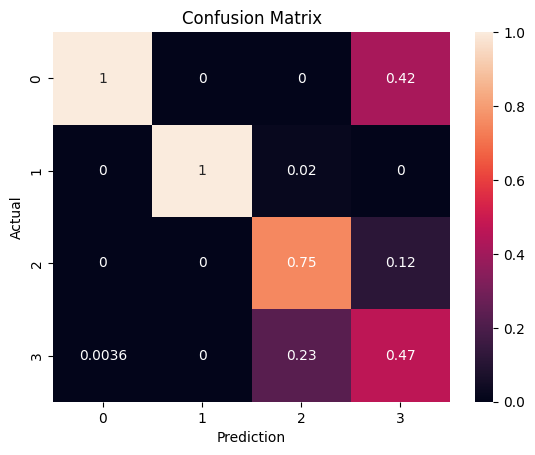

In [ ]:
from utils import print_results


print('Average Cross Validation Metrics:')
print_results(
    avg_validation_results['average accuracy'],
    avg_validation_results['average F1 macro'],
    avg_validation_results['average F1 scores'],
    avg_validation_results['average confusion matrix'])

The results are very bad even on the validation folds. Labels $0$ and $1$ are predicted fairly good, but The results for label $2$ are average and the ones for label $3$ are awful. This could be due to the fact that Naive Bayes assumes the independency of the input features, although in our dataset many features are definitely dependent on each other because they are the results of sensors measuring the same entity. 

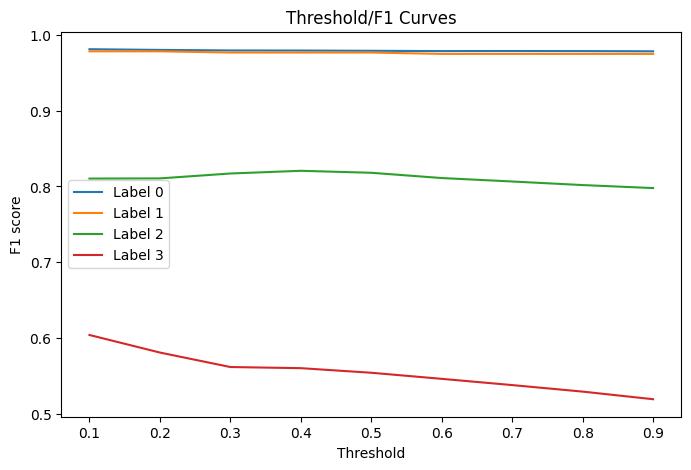

In [ ]:
if APPLY_THRESHOLD_SELECTION:
    plt.figure(figsize=(8, 5))
    plt.title(f'Threshold/F1 Curves')
    for k, v in avg_validation_results['average F1 scores by threshold'].items():
        x_val = list(v.keys())
        y_val = [v1 for v1 in v.values()]
        plt.plot(x_val, y_val, label=f'Label {int(k)}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 score')
    plt.legend()
    plt.show()

## Test Results

In [ ]:
fit_final = fit.bestModel

In [ ]:
preds = fit_final.transform(test)

In [ ]:
from utils import get_metrics


fit_final_metrics = get_metrics(
    preds,
    normalize_confusion_matrix=True)

Test results:
Accuracy: 0.866
F1 Macro: 0.662
F1 scores:
	Label 0: 0.982
	Label 1: 0.933
	Label 2: 0.452
	Label 3: 0.282


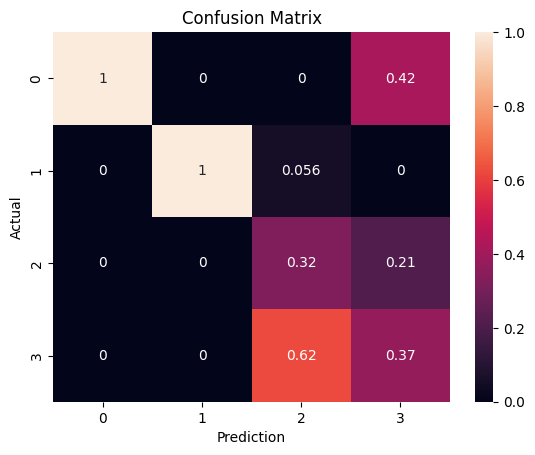

In [ ]:
from utils import print_results


print('Test results:')
print_results(
    fit_final_metrics['accuracy'],
    fit_final_metrics['F1 macro'],
    fit_final_metrics['F1 scores'],
    fit_final_metrics['confusion matrix'])

The results on the test set are even worse, as label $2$ and $3$ are furtherly lowered in terms of *F1 score*.

In [ ]:
if APPLY_THRESHOLD_SELECTION:
    best_thresholds = {
        k: max(v, key=v.get)
        for k, v in avg_validation_results['average F1 scores by threshold'].items()}
else:
    best_thresholds = { 0.: .5, 1.: .5, 2.:.5, 3: .5 }

In [ ]:
fit_final_thresholds = fit_final.copy()
fit_final_thresholds.stages[-1].setThresholds(
    list(dict(sorted(best_thresholds.items())).values()))

NaiveBayesModel: uid=NaiveBayes_b118d71374b4, modelType=gaussian, numClasses=4, numFeatures=16

In [ ]:
fit_final_thresholds.stages[-1].getThresholds()

[0.1, 0.1, 0.4, 0.1]

In [ ]:
preds = fit_final_thresholds.transform(test)

In [ ]:
from utils import get_metrics


fit_final_thresholds_metrics = get_metrics(
    preds,
    normalize_confusion_matrix=True)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test results:
Accuracy: 0.884
F1 Macro: 0.689
F1 scores:
	Label 0: 0.982
	Label 1: 0.942
	Label 2: 0.270
	Label 3: 0.563


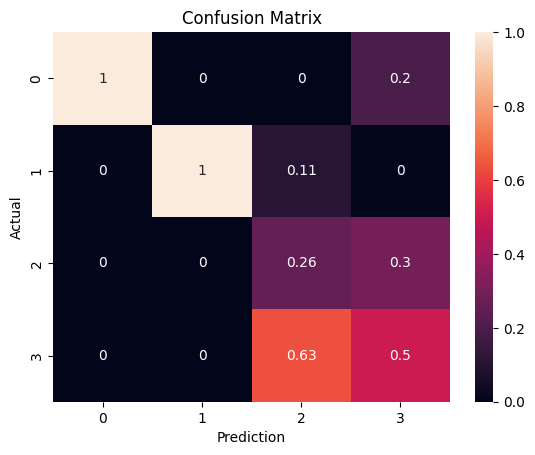

In [ ]:
from utils import print_results


print('Test results:')
print_results(
    fit_final_thresholds_metrics['accuracy'],
    fit_final_thresholds_metrics['F1 macro'],
    fit_final_thresholds_metrics['F1 scores'],
    fit_final_thresholds_metrics['confusion matrix'])

Treshold selection is not helpful, as it increases the scores of label $3$, while decreasing the ones of label $2$, resulting to a similar *F1 macro* and *accuracy* score to the model without threshold selection.

## Save the results

In [ ]:
import os

models_directory = os.path.join('.', 'model', 'nb')
os.makedirs(models_directory, exist_ok=True)

results_directory = os.path.join('.', 'results', 'nb')
os.makedirs(results_directory, exist_ok=True)

In [ ]:
import os
import pickle

# Save model and threshold model.
fit_final.save(os.path.join(models_directory, 'fit.model'))
fit_final_thresholds.save(os.path.join(models_directory, 'fit_thresholds.model'))

with open(os.path.join(results_directory, 'val.pickle'), 'wb') as f:
    pickle.dump(avg_validation_results, f)

with open(os.path.join(results_directory, 'test.pickle'), 'wb') as f:
    pickle.dump(fit_final_metrics, f)

with open(os.path.join(results_directory, 'test_thresholds.pickle'), 'wb') as f:
    pickle.dump(fit_final_thresholds_metrics, f)